# Noiseless_integrable_Traceout

In [1]:
import sys
sys.path.insert(0, '../../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import tensorflow as tf
import random
import pickle as pkl

from qiskit.quantum_info import Operator, Statevector
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from quantum_circuits import integrable_circuit, nonintegrable_circuit
from quantum_tools import circuit_to_matrix
from kraus_channels import isomery_to_kraus, KrausMap
from quantum_channel import ConcatChannel, DilutedChannel, IdentityChannel
from utils import numberToBase, saver, loader
from spectrum import complex_spacing_ratio, channel_spectrum, Spectrum, mean_spacing, coat_spectrum
from analysis import spectrum_to_angular, spectrum_to_radial, hist_ensamble
from qiskit.circuit.library import iSwapGate, XGate, YGate, HGate, CXGate, RGate, RZGate

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=1)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


## Circuits

In [2]:
def sample_csr(n, reps, circuit_type, p=0):

    d = 2**n

    map_list = []
    spectra_list = []
    csr_list = []
    for _ in tqdm(range(reps)):
        circuit = circuit_type(n+1, 10)
        U = Operator(circuit).data
        kraus_integ = isomery_to_kraus(U, rank = 2)
        if p != 0:
            kraus_chaos = KrausMap(d, d)
            kraus_chaos = DilutedChannel(IdentityChannel(d), kraus_chaos, p=p)

            kraus_map = ConcatChannel([kraus_integ, kraus_chaos])
        else:
            kraus_map = kraus_integ

        map_list.append(kraus_map)
        
        spectrum = channel_spectrum(kraus_map)
        spectra_list.append(spectrum)
        csr = complex_spacing_ratio(spectrum, log=False)
        csr_list.append(csr)

    return  map_list, spectra_list, csr_list

## Integrable

In [3]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 4
d = 2**n
reps = 10000

maps_integrable_list, spectra_integrable_list, csr_integrable_list = sample_csr(n, reps, integrable_circuit)
    

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

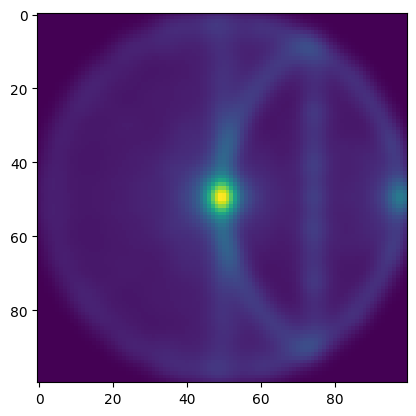

In [33]:
csr_integrable = Spectrum(csr_integrable_list)
csr_integrable_coat = coat_spectrum(csr_integrable, sigma = 0.05)

plt.imshow(csr_integrable_coat, interpolation='nearest')
plt.show()

### Radial and Angular

In [34]:
radial_integrable_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_list = spectrum_to_angular(csr_integrable_list)

## Non-Integrable Unitary

In [35]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 4
d = 2**n

reps = 10000

maps_nonintegrable_list, spectra_nonintegrable_list, csr_nonintegrable_list = sample_csr(n, reps, nonintegrable_circuit)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

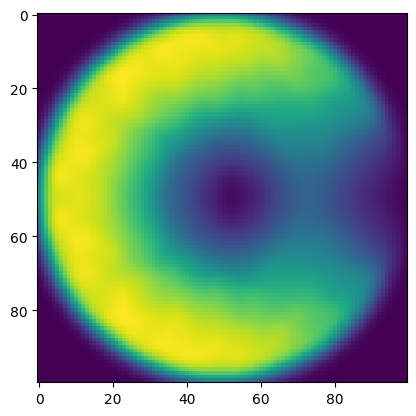

In [36]:
csr_nonintegrable = Spectrum(csr_nonintegrable_list)
csr_nonintegrable_coat = coat_spectrum(csr_nonintegrable, sigma = 0.05)

plt.imshow(csr_nonintegrable_coat, interpolation='nearest')
plt.show()

### Radial and Angular

In [40]:
radial_nonintegrable_list = spectrum_to_radial(csr_nonintegrable_list)
angular_nonintegrable_list = spectrum_to_angular(csr_nonintegrable_list)

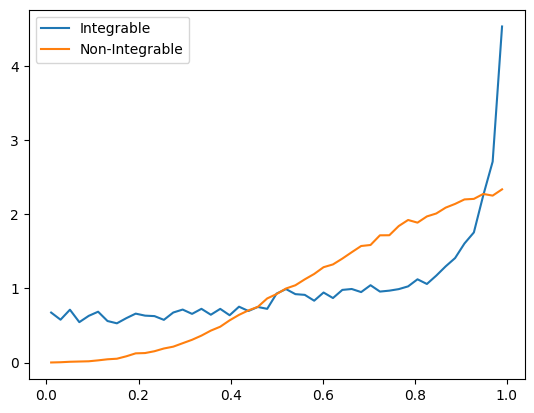

In [41]:
center_bins, hist, hist_err = hist_ensamble(radial_integrable_list, bins=np.linspace(0, 1, 50))
data = [center_bins, hist, hist_err]
saver(data, '../data/radial_integrable.data')
plt.plot(center_bins, hist, '-', label='Integrable')

center_bins, hist, hist_err = hist_ensamble(radial_nonintegrable_list, bins=np.linspace(0, 1, 50))
data = [center_bins, hist, hist_err]
saver(data, '../data/radial_nonintegrable.data')


plt.plot(center_bins, hist, '-', label='Non-Integrable')
plt.legend()
plt.show()

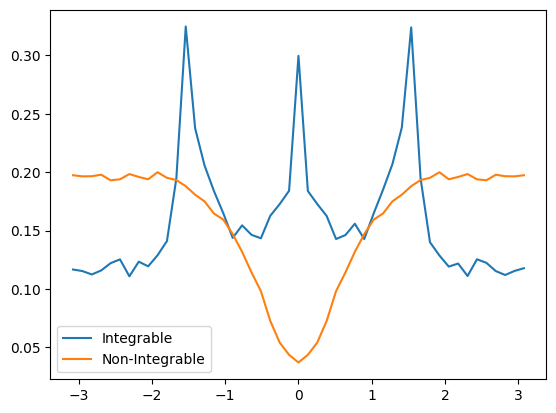

In [42]:
center_bins, hist, hist_err = hist_ensamble(angular_integrable_list, bins=np.linspace(-np.pi, np.pi, 50))
data = [center_bins, hist, hist_err]
saver(data, '../data/angular_integrable.data')
plt.plot(center_bins, hist, '-', label='Integrable')

center_bins, hist, hist_err = hist_ensamble(angular_nonintegrable_list, bins=np.linspace(-np.pi, np.pi, 50))
data = [center_bins, hist, hist_err]
saver(data, '../data/angular_nonintegrable.data')

plt.plot(center_bins, hist, '-', label='Non-Integrable')
plt.legend()
plt.show()